In [1]:
# Import required packages
import pandas as pd
import numpy as np

In [2]:
# Variables to tweak for data creation
np.random.seed(3215)
sample_size = 100

In [3]:
# Read data into environment
# See name_data_explaination for data collection methods
# AIAN - American Indian or Alaskan Native
# API - Asian Pacific Islander
last_names = pd.read_csv('data/common_surnames_census_2000.csv').rename(columns={'pct2prace': 'pctmixed'})
first_names = pd.read_csv('data/ssa_names_db.csv')

In [4]:
# Data preprocessing for Last Names

# Fields suppressed for confidentiality are assigned the value (S). 
# Replace confidentiality value with 0
# Prevents conflicts when finding max(percentages)
last_names2 = last_names.replace('(S)', 0.00)

# Convert percentage columns from strings to floats
for column in last_names2.columns[1:]:
    if last_names2[column].dtype == 'object':
        last_names2[column] = last_names2[column].astype(float)

# Create new column based on the ethnicity label with highest probability
last_names2['predominant'] = last_names2.iloc[:,5:].idxmax(1).str.replace('pct', '')

# Sample evenly through each unique dominant ethnicity
# Prevents most names being white and promotes even representation
last_names_final = last_names2.groupby('predominant').apply(lambda ethnicity: ethnicity.sample(sample_size)).reset_index(drop=True)

In [5]:
# Potential other way of handling confidentiality
# 27,649 Names after removal
'''
t = last_names.replace('(S)', None)
t.dropna()
'''

"\nt = last_names.replace('(S)', None)\nt.dropna()\n"

In [6]:
# Data preprocessing for First Names
# Multiply sample_size by 3 to keep same dimension as Last Names
# 6 Ethnicities / 2 Genders
first_names_final = first_names.groupby('gender').apply(lambda gender: gender.sample(sample_size*3)).reset_index(drop=True)

In [7]:
# Creating Full Names dataset
# Extract relevant features from First and Last Name datasets
fnames = first_names_final.iloc[:,0]
lnames = last_names_final.iloc[:,0].str.capitalize()
ffeatures = first_names_final.iloc[:,1]
lfeatures = last_names_final.iloc[:,5:]
# Join all features together in final dataset
full_names = pd.concat([fnames,lnames,lfeatures,ffeatures], axis= 1)
full_names.columns = ['first', 'last', 'pctwhite', 'pctblack', 'pctapi', 'pctaian', 'pctmixed',
       'pcthispanic', 'predominant', 'gender']
# Make names into list for ChatGPT data collection
names = [row for row in full_names[['first', 'last']].to_numpy()]

In [8]:
'''ChatGPT Response Generating Code
    Data saved in CSV file for future use'''

# import openai

# openai.api_key = open('/Users/tuomasr/Library/Mobile Documents/com~apple~CloudDocs/School/ECS/ECS 171/Group Proj/key/Group_13_Project_Key.txt').read().strip('\n')

# reply_content = []
# for person in names:
#     name = ' '.join(person)
#     text = f'Pretend you are a professor for at a popular university. You are asked by one of your students ({name}) if you can write them a letter of recommendation. Make up any information about them you feel is relevant to convey their abilities. Choose a field of study you believe is most fitting for them. Please do not include the heading'
#     completion = openai.ChatCompletion.create(
#         model="gpt-3.5-turbo", # this is "ChatGPT" $0.002 per 1k tokens
#         messages=[{"role": "user", "content": text}]
#     )

#     reply_content.append(completion.choices[0].message.content)

# # pd.DataFrame(reply_content).to_csv('chatGPT_response')

'ChatGPT Response Generating Code\n    Data saved in CSV file for future use'

In [9]:
# Add letters of Rec to the database
responses = pd.read_csv('chatGPT_responses')
full_names['GPT_letters'] = responses.iloc[:,1]
print(full_names)

       first       last  pctwhite  pctblack  pctapi  pctaian  pctmixed   
0     Baeley   Parisien     36.57      8.43    0.00    47.22      6.20  \
1    Mahniya    Charley     19.43     16.29    1.83    59.07      2.16   
2    Athziry   Greyeyes      0.00      0.00    0.00    91.40      4.07   
3    Crystel  Whitebird     17.18      0.00    0.00    72.90      7.63   
4     Vionna    Dumarce      5.59      0.00    0.00    84.92      3.35   
..       ...        ...       ...       ...     ...      ...       ...   
595  Avishai  Chenowith     96.97      0.00    0.00     0.00      0.00   
596  Carmyne      Crisp     83.79     12.07    0.37     0.59      1.70   
597    Dream     Cloran     99.63      0.00    0.00     0.00      0.00   
598    Aviel       Sago     46.92     39.74    1.41     6.41      1.92   
599   Deymar   Burkhard     95.39      0.46    1.00     0.00      1.46   

     pcthispanic predominant gender   
0           0.00        aian      F  \
1           1.23        aian     

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

documents = full_names['GPT_letters'].copy()

# process data with tf-idf 
vectorizer = TfidfVectorizer()
scores = vectorizer.fit_transform(documents).toarray()

# get term/feature names
terms = vectorizer.get_feature_names_out()

# form table of names with tf-idf scores corresponding to each term in their responses
names = full_names['first'] + ' ' + full_names['last']
name_scores = pd.DataFrame(scores, columns=terms)
name_scores.insert(0, 'Full_Name', names)
name_scores.insert(1, 'Pre_Race', full_names['predominant'])
name_scores.insert(2, 'Pre_Gender', full_names['gender'])

# put into csv file?
display(name_scores)

,Full_Name,Pre_Race,Pre_Gender,10,101,19,2020,2021,30,81,...,ziff,zin,ziyu,zohaib,zohra,zola,zone,zuni,zuriana,zyanna
0,Baeley Parisien,aian,F,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Mahniya Charley,aian,F,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Athziry Greyeyes,aian,F,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Crystel Whitebird,aian,F,0.0,0.0,0.0,0.0,0.081326,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Vionna Dumarce,aian,F,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Avishai Chenowith,white,M,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,Carmyne Crisp,white,M,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,Dream Cloran,white,M,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,Aviel Sago,white,M,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

(-0.5, 899.5, 499.5, -0.5)

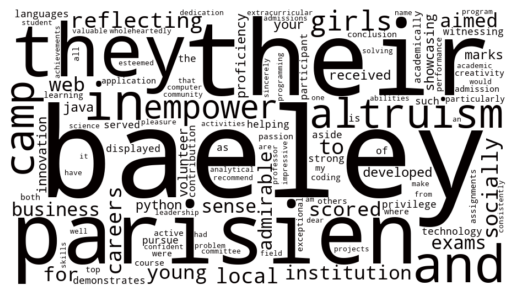

In [12]:
data_copied = name_scores.copy()
data_copied = data_copied.drop(columns = ["Full_Name", "Pre_Race", "Pre_Gender"])
data_word_clouds = data_copied.transpose()


# change the value to black
def black_color (word, font_size, position, orientation, random_state = None, **kwargs):
    return ("hsl(0, 100%, 1%)")

# set the background color to white
# word cloud for the fisrt person "Baeley Parisien"
wordcloud = WordCloud(background_color = "white", width = 900, height = 500, max_words = 500).generate_from_frequencies(data_word_clouds[0])

# set the word color to black
wordcloud.recolor(color_func = black_color)

# set the figsize
# plt.figure(figsize = [15, 10])
       
plt.imshow(wordcloud, interpolation = "bilinear")

plt.axis("off")